# Time-Varying Effects of Market Uncertainties on Crude Oil Return

## Plan
I examine the 12-month change in nominal WTI returns in response to economic, geopolticial and financial uncertainties, and how responses have changed over time.

Consistent with Kilian (2008) and Kilian & Hicks (2013), I use a (non-autoregressive) distributed lag model to estimate the overall effect of shocks in uncertainty over a period of 12 months. In doing so, I recognize underlying assumptions that a) shocks are predetermined, and b) shocks can be readily observed. 

To obtain continuous and non-proprietary measures for uncertainty, I look at established indices such that approximate uncertainty: namely the Economic Policy Uncertainty Index (EPU), Geopolitical Risk Index (GPR), and CBOE Volatility Index (VIX). Shock values are defined as the difference between % changes in the index and the 12-month rolling average.

Adding to the distributed lag methodology, I also come up with a method to estimate annual changes in model coefficients by shifting the start and end of the sample data over annual intervals, constructed so that the 12 datapoints each year are included in both shifts. The difference between coefficients obtained for each direction of shifting is then averaged to obtain an estimate of the real coefficients for that year (since using just 12 datapoints would be insufficient to run a lagged regresssion). Although the estimates obtained may not be accurate in magnitude, they should be representative of the overall shape over time.

## Model

For the following let WTI be the nominal price of WTI crude, S be the shock variable and I the value of the the index used.

$\Delta{WTI}_t = \alpha + \sum_{p=0}^{12} \beta_p S_{t-p} + \epsilon_t$

where

$S_t = \Delta{I_t} - \Delta{(\frac{1}{12}\sum_{j=0}^{11} I_{t-j})}$

The magnitude of WTI response at month p after the shock is thus given by $\beta_p$.

WTI data is sourced from EIA, while the EPU and GPR indices were sourced from the authors and VIX monthly adjusted closing values from Yahoo Finance.

In [1]:
from utils import *
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
statsmodels: 0.13.0


## EPU

In [2]:
wti = load('data/WTI.csv').pct_change().dropna()
spot = clean_series('spot', wti)
c1 = clean_series('contract_1', wti)
c3 = clean_series('contract_3', wti)

In [3]:
epu = load('data/EPUGlobal.csv')
epu_shock = calc_shock('GEPU_current', epu)

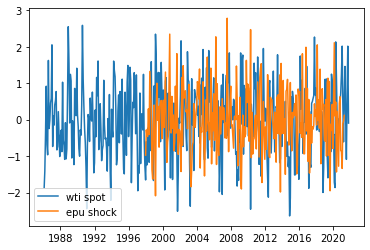

In [4]:
plt.plot(spot, label='wti spot')
plt.plot(epu_shock, label='epu shock')
plt.legend()

Note that all time series data are standardized annually and seasonally adjusted each month.

In [5]:
model1 = dl('spot', 'GEPU_current', spot.join(epu_shock))
model2 = dl('contract_1', 'GEPU_current', c1.join(epu_shock))
model3 = dl('contract_3', 'GEPU_current', c3.join(epu_shock))

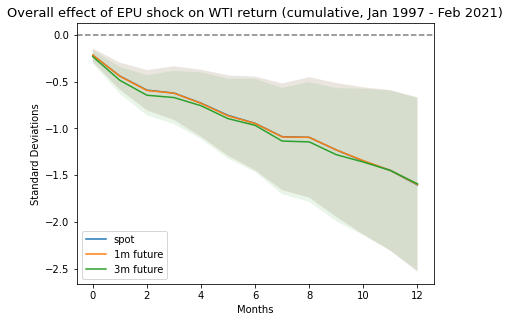

In [6]:
draw((model1, model2, model3), labels=('spot', '1m future', '3m future'), cumulative=True)
plt.title('Overall effect of EPU shock on WTI return (cumulative, Jan 1997 - Feb 2021)', fontsize=13)
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

This is the cumulative shock response at months 0 to 12 after the shock occurs with 1 standard error bands. Due to the transformations done on the time series to ensure an unbiased fit, the proper interpretation is that (ceteris paribus) a 1 standard deviation increase in the shock variable (change in EPU relative to the 12-month rolling average) corresponds to a total -1.5 standard deviation decrease in WTI returns over 12 months.

Note that standard deviations are computed annually (see annotation above for time series data).

In [7]:
spot_shift1 = time_shift('spot', 'GEPU_current', spot.join(epu_shock), start_yr=2000, end_yr=2018)
c1_shift1 = time_shift('contract_1', 'GEPU_current', c1.join(epu_shock), start_yr=2000, end_yr=2018)
c3_shift1 = time_shift('contract_3', 'GEPU_current', c3.join(epu_shock), start_yr=2000, end_yr=2018)

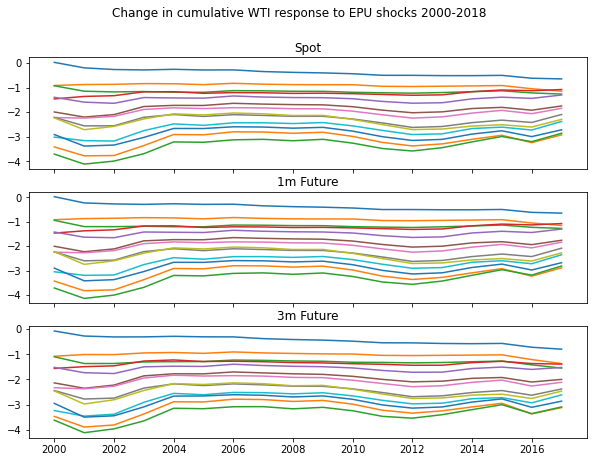

In [8]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7))
fig.suptitle('Change in cumulative WTI response to EPU shocks 2000-2018')
axs[0].plot(spot_shift1)
axs[0].set_title('Spot')
axs[1].plot(c1_shift1)
axs[1].set_title('1m Future')
axs[2].plot(c3_shift1)
axs[2].set_title('3m Future')
plt.show()

The above graph shows how the coefficients estimates change over time for response to EPU shocks, where each line represents cumulative response at month p in the model. For robustness, coefficients were estimated by running two series of regressions in two 'directions'. The 'forward' (in time) estimates were gotten by starting the sample from 2000-01-01 and iteratively excluding the oldest 12 months from the sample size up to 2018-01-01. The 'backward' estimates were gotten by ending the sample at 2000-12-31 for the first run and iteratively increasing the sample size by 12 months each run up to 2018-12-31. The mean between coefficient estimates for the forward and backward runs were then taken to exclude anomalies and difference in trends at the outer edges of the data not included in the period shown. I believe that this method of estimation solves the problem of being unable to generate 12-month estimates for a single year due to there being only 12 datapoints available. While this method may not generate the most accurate results, I believe it should give a robust representation of any temporal trends.

From the graphs, we see a gradual tightening of cumulative effect of EPU shocks on WTI. WTI spot and futures are quicker to adjust to shocks in the first couple of months, while the cumulative effects are not felt as sharply 6-12 months onwards. We also see there are periods such as 2001, 2012 and 2016 when the effect of EPU shocks were longer-lasting than usual. Coincidentally, these periods correspond with the 9/11 attacks, European debt crisis and Brexit, so it is expected. However, we do not see the 2008 global financial crisis having an effect.

## GPR

In [9]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

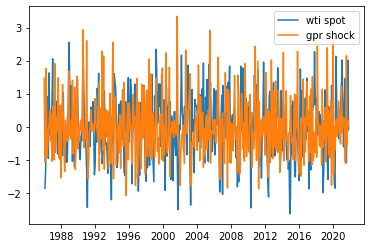

In [10]:
plt.plot(spot, label='wti spot')
plt.plot(gpr_shock, label='gpr shock')
plt.legend()

In [11]:
model4 = dl('spot', 'GPRI', spot.join(gpr_shock))
model5 = dl('contract_1', 'GPRI', c1.join(gpr_shock))
model6 = dl('contract_3', 'GPRI', c3.join(gpr_shock))

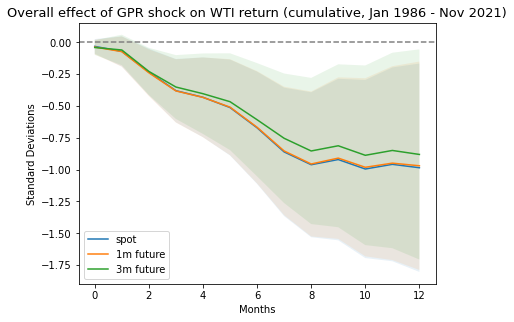

In [12]:
draw((model4, model5, model6), labels=('spot', '1m future', '3m future'), cumulative=True)
plt.title('Overall effect of GPR shock on WTI return (cumulative, Jan 1986 - Nov 2021)', fontsize=13)
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

Here we see that on average, a 1 standard deviation in GPR shock corresponds to a total -1 standard deviation in WTI returns in the next 12 months.

In [13]:
spot_shift2 = time_shift('spot', 'GPRI', spot.join(gpr_shock), start_yr=1990, end_yr=2019)
c1_shift2 = time_shift('contract_1', 'GPRI', c1.join(gpr_shock), start_yr=1990, end_yr=2019)
c3_shift2 = time_shift('contract_3', 'GPRI', c3.join(gpr_shock), start_yr=1990, end_yr=2019)

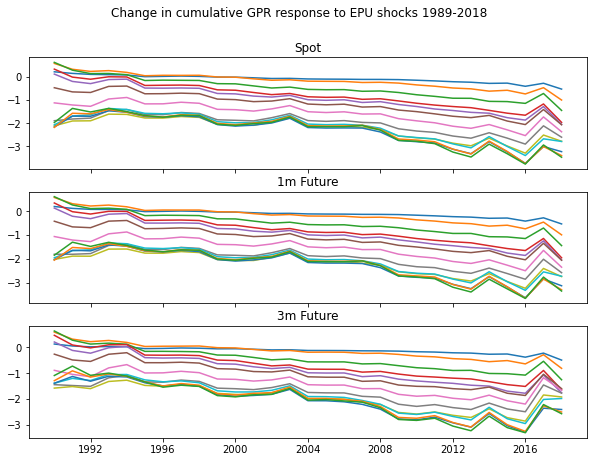

In [14]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7))
fig.suptitle('Change in cumulative GPR response to EPU shocks 1989-2018')
axs[0].plot(spot_shift2)
axs[0].set_title('Spot')
axs[1].plot(c1_shift2)
axs[1].set_title('1m Future')
axs[2].plot(c3_shift2)
axs[2].set_title('3m Future')
plt.show()

From the graph above, we see that WTI is responding more negatively to GPR shocks like with EPU. However, the cumulative effect of GPU shocks also have a greater effect on GPR responses 6-12 months on. Disruptions to this trend can be seen in 2003, 2011, 2014 and 2018, where 6-12 month cumulative effects were reduced relative to the shocks. Coincidentally, these periods correspond with the US invasion of Iraq, start of the Arab Spring, the Russo-Ukranian war and the Kerch Strait Incident. The reduced shocks should not be taken as a sign that those events were insignificant, but rather they represent supply-side disruptions that helped push up prices rather than depress them. It is interesting, therefore, that overall the crude market increasingly characterize geopolitical uncertainty with demand-side uncertainty.

## VIX

In [15]:
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

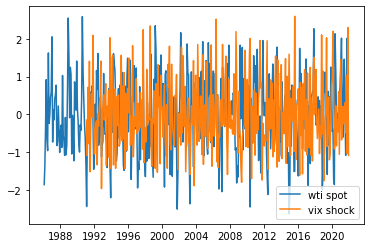

In [16]:
plt.plot(spot, label='wti spot')
plt.plot(vix_shock, label='vix shock')
plt.legend()

In [17]:
model7 = dl('spot', 'VIX', spot.join(vix_shock))
model8 = dl('contract_1', 'VIX', c1.join(vix_shock))
model9 = dl('contract_3', 'VIX', c3.join(vix_shock))

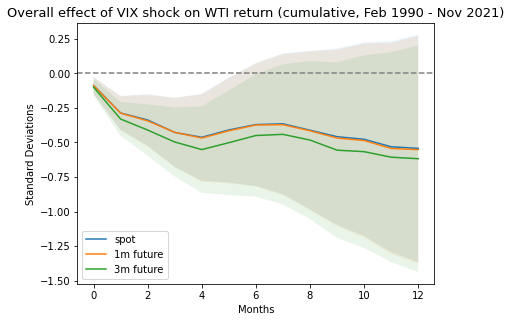

In [18]:
draw((model7, model8, model9), labels=('spot', '1m future', '3m future'), cumulative=True)
plt.title('Overall effect of VIX shock on WTI return (cumulative, Feb 1990 - Nov 2021)', fontsize=13)
plt.ylabel('Standard Deviations')
plt.xlabel('Months')
plt.show()

In [19]:
spot_shift3 = time_shift('spot', 'VIX', spot.join(vix_shock), start_yr=1994, end_yr=2019)
c1_shift3 = time_shift('contract_1', 'VIX', c1.join(vix_shock), start_yr=1994, end_yr=2019)
c3_shift3 = time_shift('contract_3', 'VIX', c3.join(vix_shock), start_yr=1994, end_yr=2019)

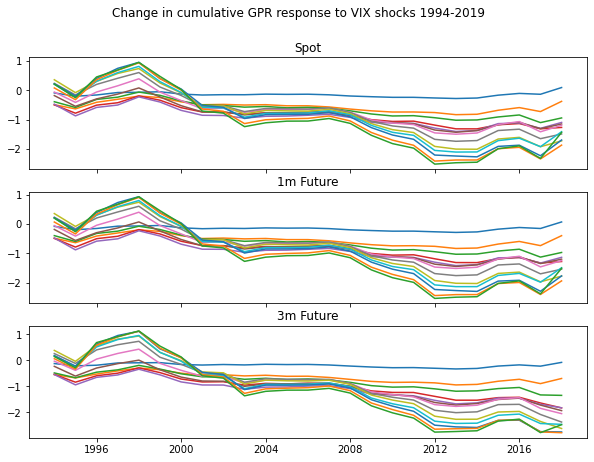

In [20]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7))
fig.suptitle('Change in cumulative GPR response to VIX shocks 1994-2019')
axs[0].plot(spot_shift3)
axs[0].set_title('Spot')
axs[1].plot(c1_shift3)
axs[1].set_title('1m Future')
axs[2].plot(c3_shift3)
axs[2].set_title('3m Future')
plt.show()

This relationship is really interesting - it seems that S&P500 downturns (1991, 2000, 2008) decrease 6-12 month crude returns in response to VIX shocks over the next 4 years, after which responses remain stable until the next bear market. There was also a period from 1995 to 2000 when 6-12 months cumulative returns were positive with every shock in the VIX, coinciding with the dotcom bubble and Greenspan's period of 'irrational exuberance'. Additionally, initial returns today appear to move towards positive correlation with VIX shocks.